# Abstract
With this dataset, I intend to find the relationship between macro/micro nutrients and Kilocalories in food. I will use this information to build a model that can predict the calories in a food based on nutritional information.



In [608]:
from statistics import LinearRegression

import mlxtend
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vraosharma-northeastern/exploratory-data-analysis/main/Nutrition%20/food.csv

zsh:1: command not found: wget


In [609]:
# Importing the necessary libraries
import numpy as np
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import shapiro
from sklearn.feature_selection import RFE
import statsmodels.regression.linear_model as lm
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Dataset Overview & Cleanup

In [610]:
#Reading the file into a dataframe and viewing the first few rows
df = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in df.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    df.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
df.head()

,Category,Description,Nutrient Data Bank Number,Alpha Carotene,Ash,Beta Carotene,Beta Cryptoxanthin,Carbohydrate,Cholesterol,Choline,...,Major Minerals.Potassium,Major Minerals.Sodium,Major Minerals.Zinc,Vitamins.Vitamin A - IU,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


As we can see above, each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. Some foods have multiple entries in the dataset because they were prepared in different ways, e.g. raw, cooked, fried, etc. Additionally, some foods have multiple entries because they were prepared with different ingredients, e.g. with or without salt, with or without sugar, etc.

The consistency of the data also presents a challenge. For example, the *Category* column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I am not sure if this is intentional or not, but I will leave this data as is for now. To clean this up, I could use GPT to classify the foods into categories, but that is outside the scope of this project.

**What are the data types?**: Below, we can see the data types in this dataset are object (string), float64, and int64.

In [611]:
# Show data types and count of attributes per that type
df.dtypes.value_counts()

float64    25
int64      19
object      4
dtype: int64

**Are there missing values?**: As we can see below, there are only null values in the two 'Household Weight Description' columns.

In [612]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Household Weights.2nd Household Weight Description    41.818427
Household Weights.1st Household Weight Description     6.340213
Category                                               0.000000
Description                                            0.000000
Fat.Polysaturated Fat                                  0.000000
Fat.Saturated Fat                                      0.000000
Fat.Total Lipid                                        0.000000
Household Weights.1st Household Weight                 0.000000
Household Weights.2nd Household Weight                 0.000000
Major Minerals.Calcium                                 0.000000
Major Minerals.Copper                                  0.000000
Major Minerals.Iron                                    0.000000
Major Minerals.Magnesium                               0.000000
Major Minerals.Phosphorus                              0.000000
Major Minerals.Potassium                               0.000000
Major Minerals.Sodium                   

Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

Also, because Household Weight Description doesn't really tell us anything that the *Household Weights.1st Household Weight* already containes, we will drop *Household Weights.1st Household Weight Description* as well.

In [613]:
# Drop 'Household Weight Description' columns
df.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight','Household Weights.1st Household Weight Description'], axis=1, inplace=True)

Despite having only non-null values, both categorical and numeric attributes of this dataset have a few "placeholder" values. Let's quantify these.


In [614]:
# Find the number of values in the 'Category' column that ci match '%no category%'
df[df['Category'].str.contains('no category', case=False)]['Category'].count()/ len(df)

0.026709834075273168

We can see that the *Category* column has less than 3% of its values labeled 'no category'. This is not a significant amount of data. Because we're trying to predict Kilocalories, and we don't care too much about the taxonomy of food types, we will keep these records.

Let's now target the numeric columns. We will look for values that are 0, which are likely placeholders for missing data.

In [615]:
# Show the percentage of 0s in each numeric column of the dataset. In another table, show the percentage of 1s in each numeric column of the dataset.

df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x[x == 0].count() / len(df)).sort_values(ascending=False)

Lycopene                                  0.966275
Beta Cryptoxanthin                        0.920005
Alpha Carotene                            0.918117
Refuse Percentage                         0.804667
Lutein and Zeaxanthin                     0.788075
Beta Carotene                             0.739512
Retinol                                   0.716444
Vitamins.Vitamin K                        0.571024
Choline                                   0.547552
Vitamins.Vitamin A - RAE                  0.508701
Vitamins.Vitamin C                        0.505733
Vitamins.Vitamin B12                      0.499933
Sugar Total                               0.482800
Cholesterol                               0.476190
Fiber                                     0.461082
Vitamins.Vitamin E                        0.458249
Vitamins.Vitamin A - IU                   0.362067
Manganese                                 0.244975
Selenium                                  0.242277
Pantothenic Acid               

Because we're dealing with a variety of foods, it makes sense that certain nutrients would be absent, so we will not impute any of these values. However, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0.

In [616]:
# Drop rows where Household Weights.1st Household Weight is 0
df = df[df['Household Weights.1st Household Weight'] != 0]

Next, let's limit the scope of our dataset to exclude information that gives is found in small quantities in food. We will remove the following columns to simplify our analysis because we don't care about their correlation to KCAL:
1. **Alpha Carotene**
2. **Beta Carotene**
3. **Beta Cryptoxanthin**
4. **Lycopene**
5. **Lutein and Zeaxanthin**
6. **Retinol**
7. **Riboflavin**
8. **Selinium**
9. **Thiamin**
10. **Choline**
11. **Manganese**
12. **Niacin**
13. **Pantothenic Acid**
14. **Refuse Percentage**

In [617]:
# Drop columns that are not relevant to our analysis
df.drop(['Alpha Carotene', 'Beta Carotene', 'Beta Cryptoxanthin', 'Lycopene', 'Lutein and Zeaxanthin', 'Retinol', 'Riboflavin', 'Selenium', 'Thiamin', 'Choline', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Refuse Percentage'], axis=1, inplace=True)

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [618]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
df.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
0 Ash: g
1 Carbohydrate: g
3 Cholesterol: mg
5 Fat.Monosaturated Fat: g
6 Fat.Polysaturated Fat: g
7 Fat.Saturated Fat: g
8 Fat.Total Lipid: g
9 Fiber: g
10 Household Weights.1st Household Weight: g
12 Kilocalories: kcal
13 Major Minerals.Calcium: mg
14 Major Minerals.Copper: mg
15 Major Minerals.Iron: mg
16 Major Minerals.Magnesium: mg
17 Major Minerals.Phosphorus: mg
18 Major Minerals.Potassium: mg
19 Major Minerals.Sodium: mg
20 Major Minerals.Zinc: mg
22 Protein: g
24 Sugar Total: g
26 Vitamins.Vitamin A - RAE: µg
27 Vitamins.Vitamin B12: µg
28 Vitamins.Vitamin B6: µg
29 Vitamins.Vitamin C: µg
30 Vitamins.Vitamin E: mg
31 Vitamins.Vitamin K: µg
32 Water: g

In [619]:
# Show the first row of the dataset in alphabetical order
df.sort_index(axis=1).head(1)

,Ash,Carbohydrate,Category,Cholesterol,Description,Fat.Monosaturated Fat,Fat.Polysaturated Fat,Fat.Saturated Fat,Fat.Total Lipid,Fiber,...,Nutrient Data Bank Number,Protein,Sugar Total,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K,Water
0,2.11,0.06,BUTTER,215,"BUTTER,WITH SALT",21.021,3.043,51.368,81.11,0.0,...,1001,0.85,0.06,684,0.17,0.003,0.0,2.32,7.0,15.87


 **Which independent variables have missing data? How much?**: Now that we've cleaned the dataset of irrelevant data, let's look at the missing values again. We can see below that there are no missing values. Remember, we have those  'no category' records in the *Category* column (3%).

In [620]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Category                                  0.0
Description                               0.0
Vitamins.Vitamin E                        0.0
Vitamins.Vitamin C                        0.0
Vitamins.Vitamin B6                       0.0
Vitamins.Vitamin B12                      0.0
Vitamins.Vitamin A - RAE                  0.0
Major Minerals.Zinc                       0.0
Major Minerals.Sodium                     0.0
Major Minerals.Potassium                  0.0
Major Minerals.Phosphorus                 0.0
Major Minerals.Magnesium                  0.0
Major Minerals.Iron                       0.0
Major Minerals.Copper                     0.0
Major Minerals.Calcium                    0.0
Household Weights.1st Household Weight    0.0
Fat.Total Lipid                           0.0
Fat.Saturated Fat                         0.0
Fat.Polysaturated Fat                     0.0
Fat.Monosaturated Fat                     0.0
Water                                     0.0
Sugar Total                       

**What are the likely distributions of the numeric variables?**: Now that we've cleaned up the dataset, let's see the distributions of the numeric variables. We will use a histogram to visualize the distributions of the numeric variables.

## Data Profiling

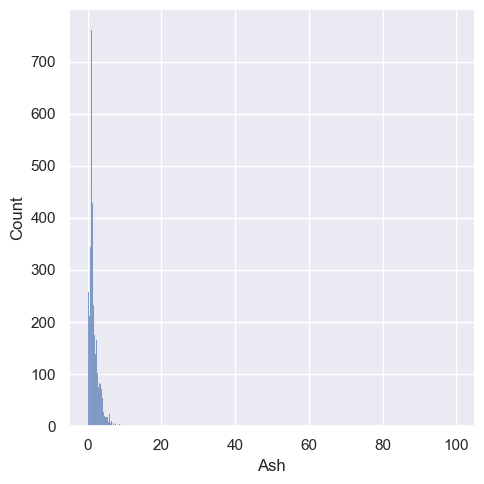

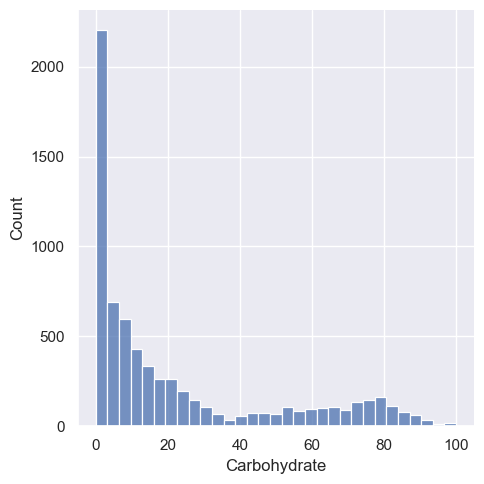

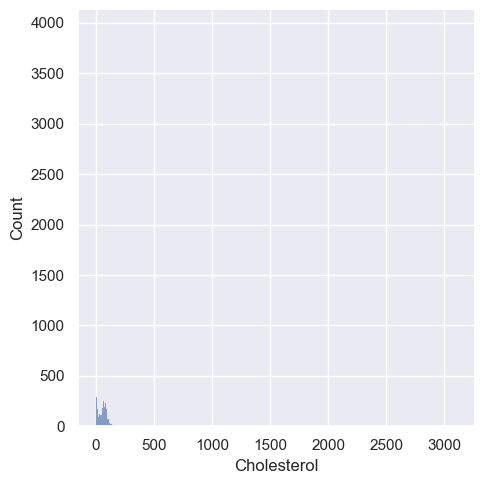

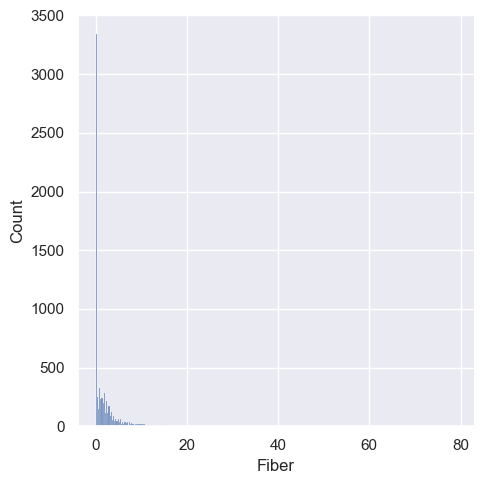

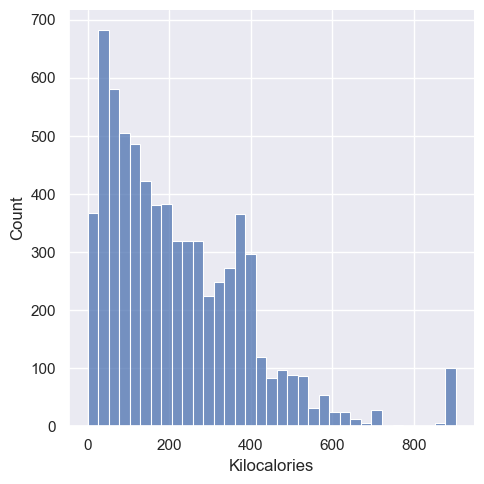

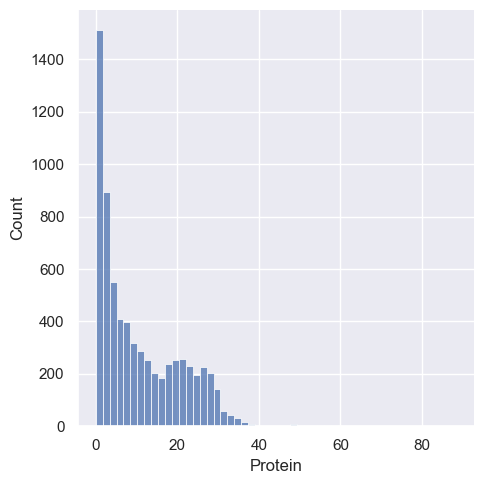

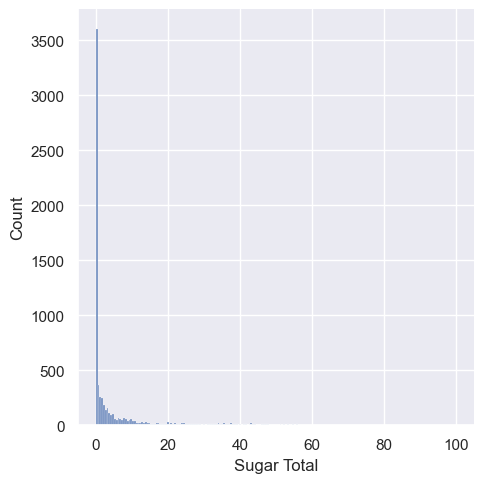

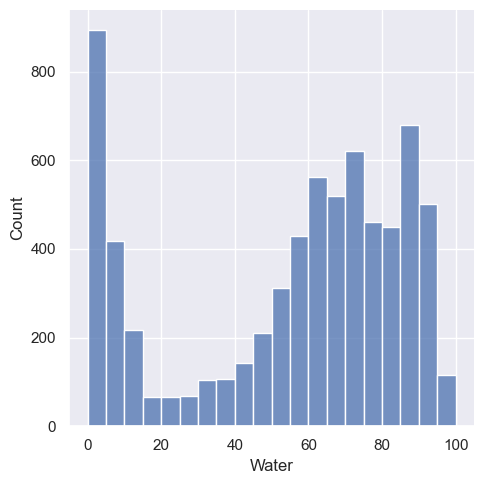

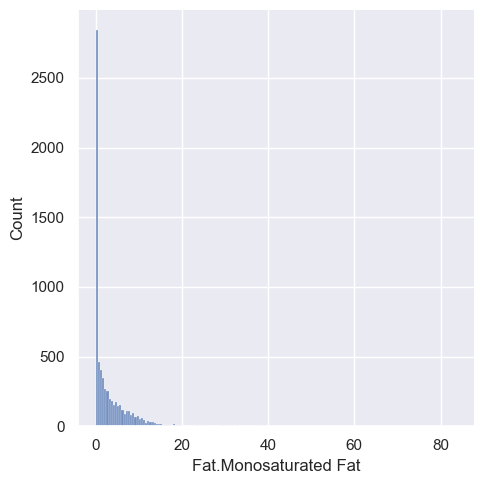

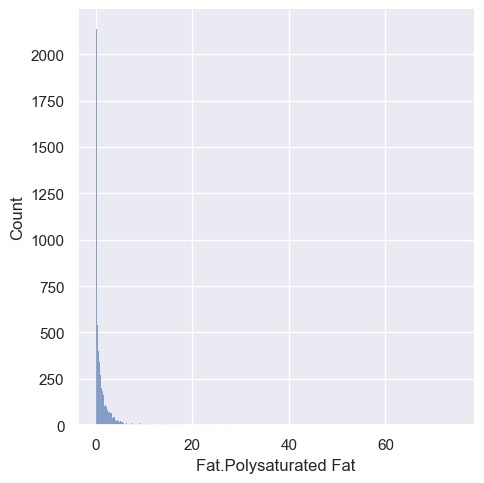

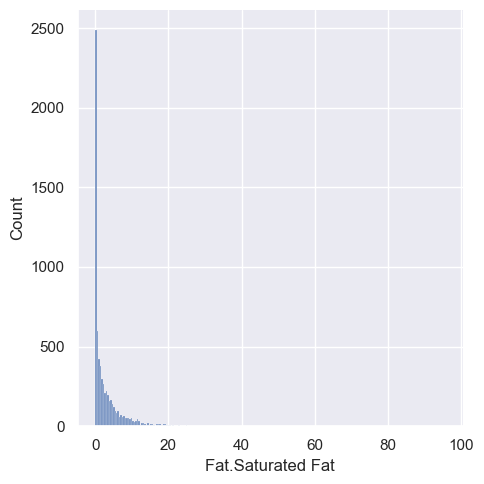

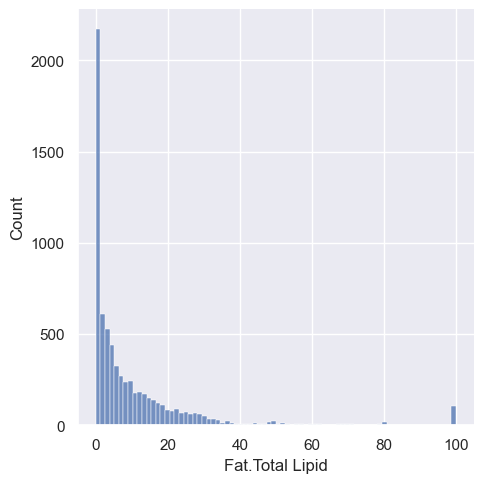

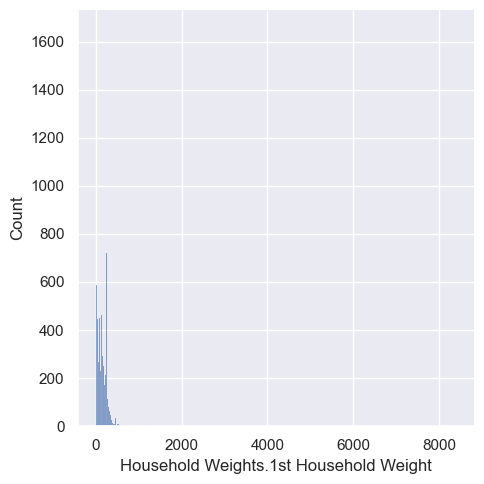

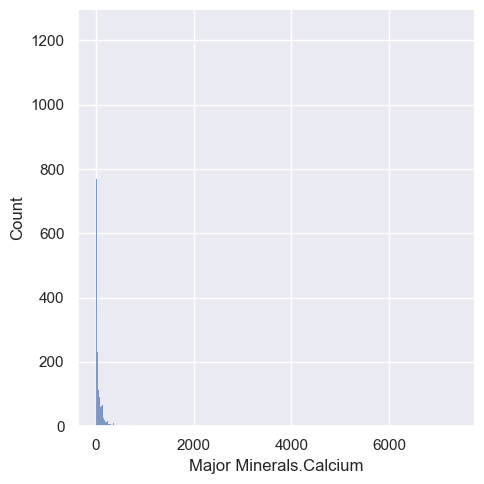

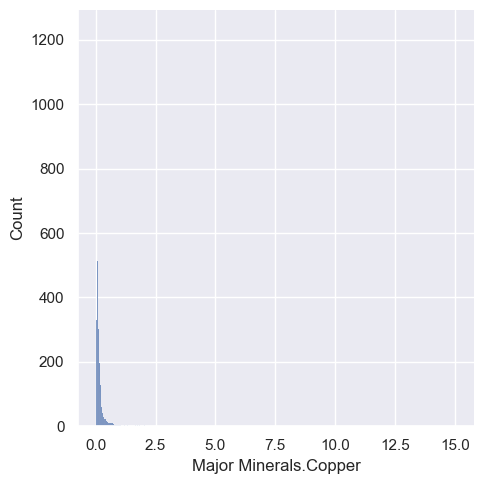

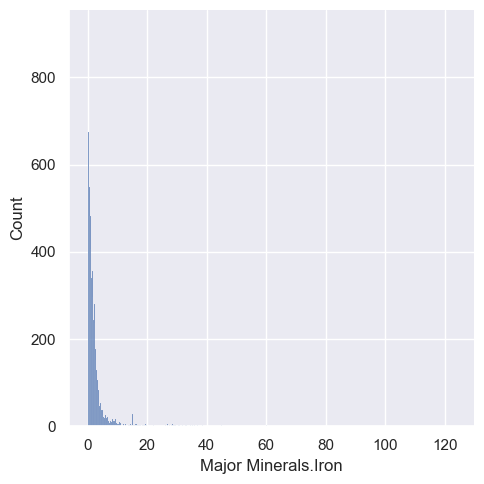

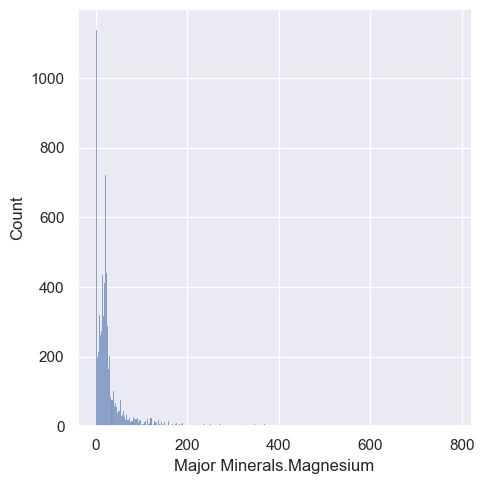

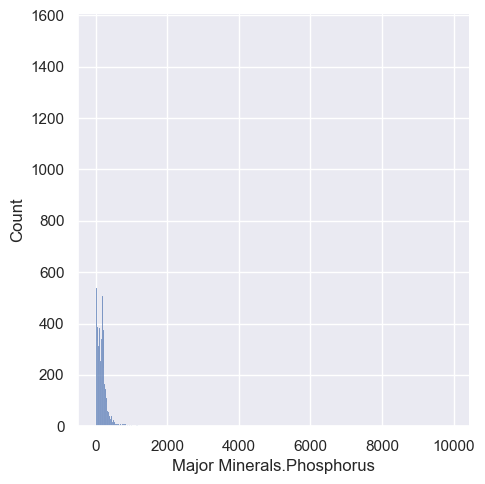

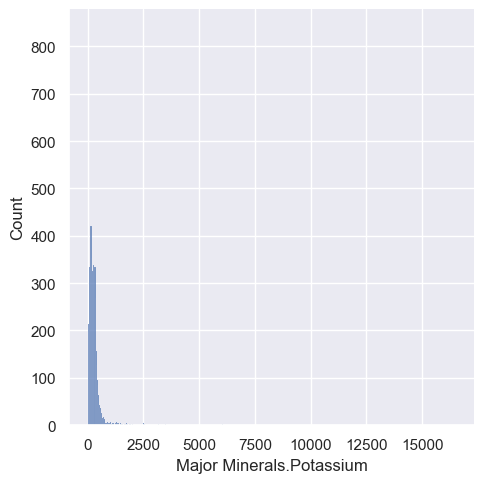

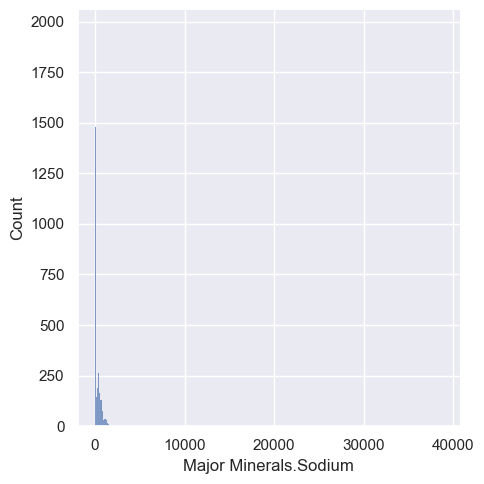

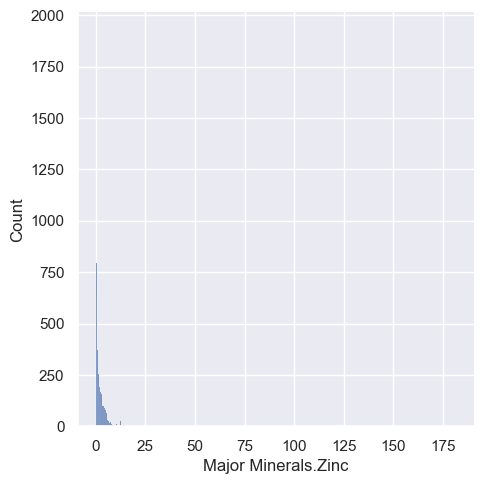

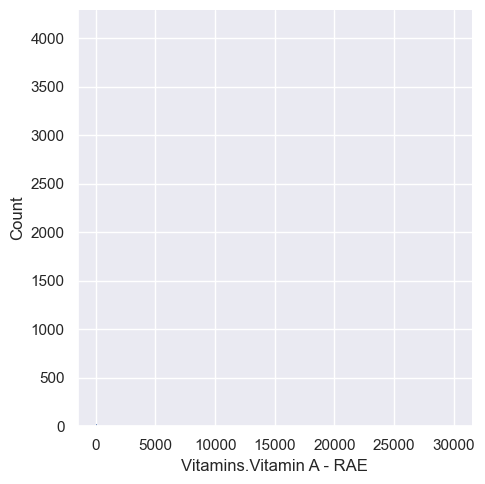

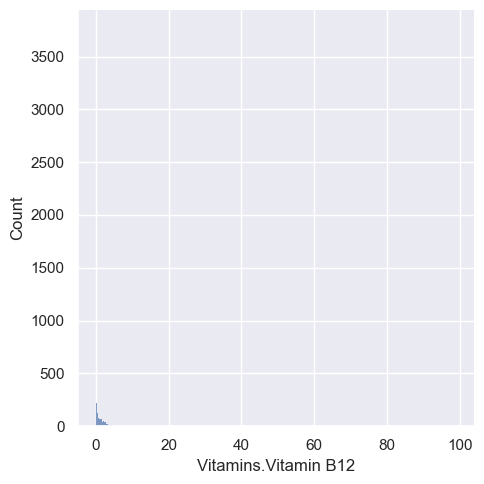

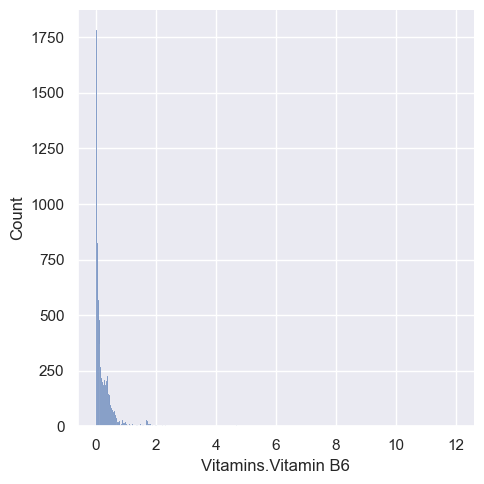

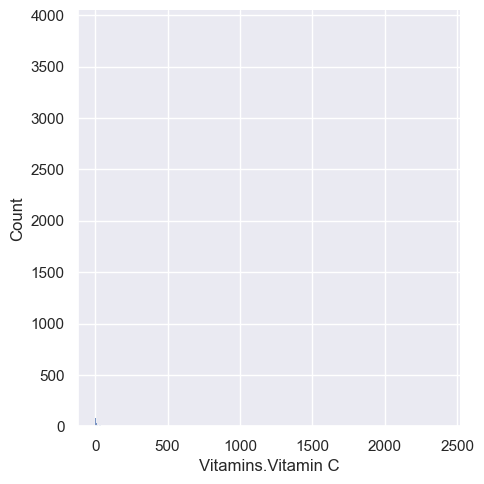

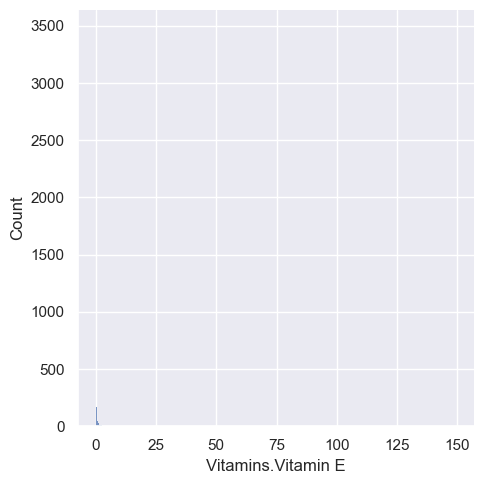

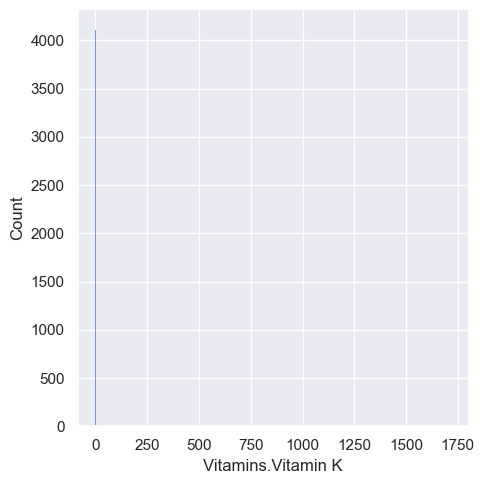

In [621]:
# Add the numeric columns excluding Nutrient Data Bank Number to a list
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

#create a histogram for each numeric column
for column in numeric_cols.columns:
    sns.set(rc={"figure.figsize": (8, 4)});
    sns.displot(df[column])
    plt.show()



We can see that the distributions of the numeric variables are very right-tailed. This is expected because not all foods have the same nutritional value. For example, some foods are very rich in Vitamin A like Cod Liver, while others have none.

The only variable that looks roughly normal is *Water*. Let's perform the Shapiro-Wilk test to verify if Water's or any other of the distributions are normal.

In [622]:
# Perform the Shapiro-Wilk test on each numeric column excluding Nutrient Data Bank Number
for column in numeric_cols.columns:
    stat, p = shapiro(df[column])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('{} looks Normal (fail to reject H0)'.format(column))
    else:
        print('{} does not look Normal (reject H0)'.format(column))

Statistics=0.338, p=0.000
Ash does not look Normal (reject H0)
Statistics=0.779, p=0.000
Carbohydrate does not look Normal (reject H0)
Statistics=0.234, p=0.000
Cholesterol does not look Normal (reject H0)
Statistics=0.487, p=0.000
Fiber does not look Normal (reject H0)
Statistics=0.899, p=0.000
Kilocalories does not look Normal (reject H0)
Statistics=0.867, p=0.000
Protein does not look Normal (reject H0)
Statistics=0.533, p=0.000
Sugar Total does not look Normal (reject H0)
Statistics=0.881, p=0.000
Water does not look Normal (reject H0)
Statistics=0.530, p=0.000
Fat.Monosaturated Fat does not look Normal (reject H0)
Statistics=0.367, p=0.000
Fat.Polysaturated Fat does not look Normal (reject H0)
Statistics=0.472, p=0.000
Fat.Saturated Fat does not look Normal (reject H0)
Statistics=0.609, p=0.000
Fat.Total Lipid does not look Normal (reject H0)
Statistics=0.359, p=0.000
Household Weights.1st Household Weight does not look Normal (reject H0)
Statistics=0.281, p=0.000
Major Minerals.C

/Users/vraosharma/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As we can see above, none of the distributions are normal. This is expected because the distributions are right-tailed. We will not transform the data to make it normal because we are not using any models that require normality.

***Note to Reader*** - I am not sure if the Shapiro-Wilk test is the perfect test to use here. Also, I attempted to show QQ plots for this data to understand if the distributions were another common distribution, but I was not able to tell.

## Feature Selection
Now that we have an idea of what we're working with, let's see which columns are the most useful for predicting Kilocalories. We will use three methods to determine which features are the most useful:
1. **Pearson's Correlation**: We will use Pearson's Correlation to determine which features are the most correlated to Kilocalories. We will use a threshold of 0.5.
2. **Sequential Feature Selection**: We will use Sequential Feature Selection to determine which features are the most useful. We will use a linear regression model to determine the best features. We will use a step size of 1 and a cross-validation of 5.
3. **Variance Thresholding**: We will use Variance Thresholding to determine which features are the most useful. We will use a threshold of 0.2.

In [623]:
# Create three copies of our df for feature selection
df_fs_correlation = df.copy()
df_fs_SFS = df.copy()
df_fs_vt = df.copy()

# Only keep feature candidates
df_fs_correlation = df_fs_correlation.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)
df_fs_SFS = df_fs_SFS.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)
df_fs_vt = df_fs_vt.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

 **Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)**
For our target variable, we will use *Kilocalories* because it is a measure of energy and is a good indicator of the nutritional value of a food. Below we will use a few methods to determine which independent variables are useful to predict *Kilocalories*.

First up, let's use ***Pearson's Correlation*** look at the relationships between *Kilocalories* and the other numeric variables.

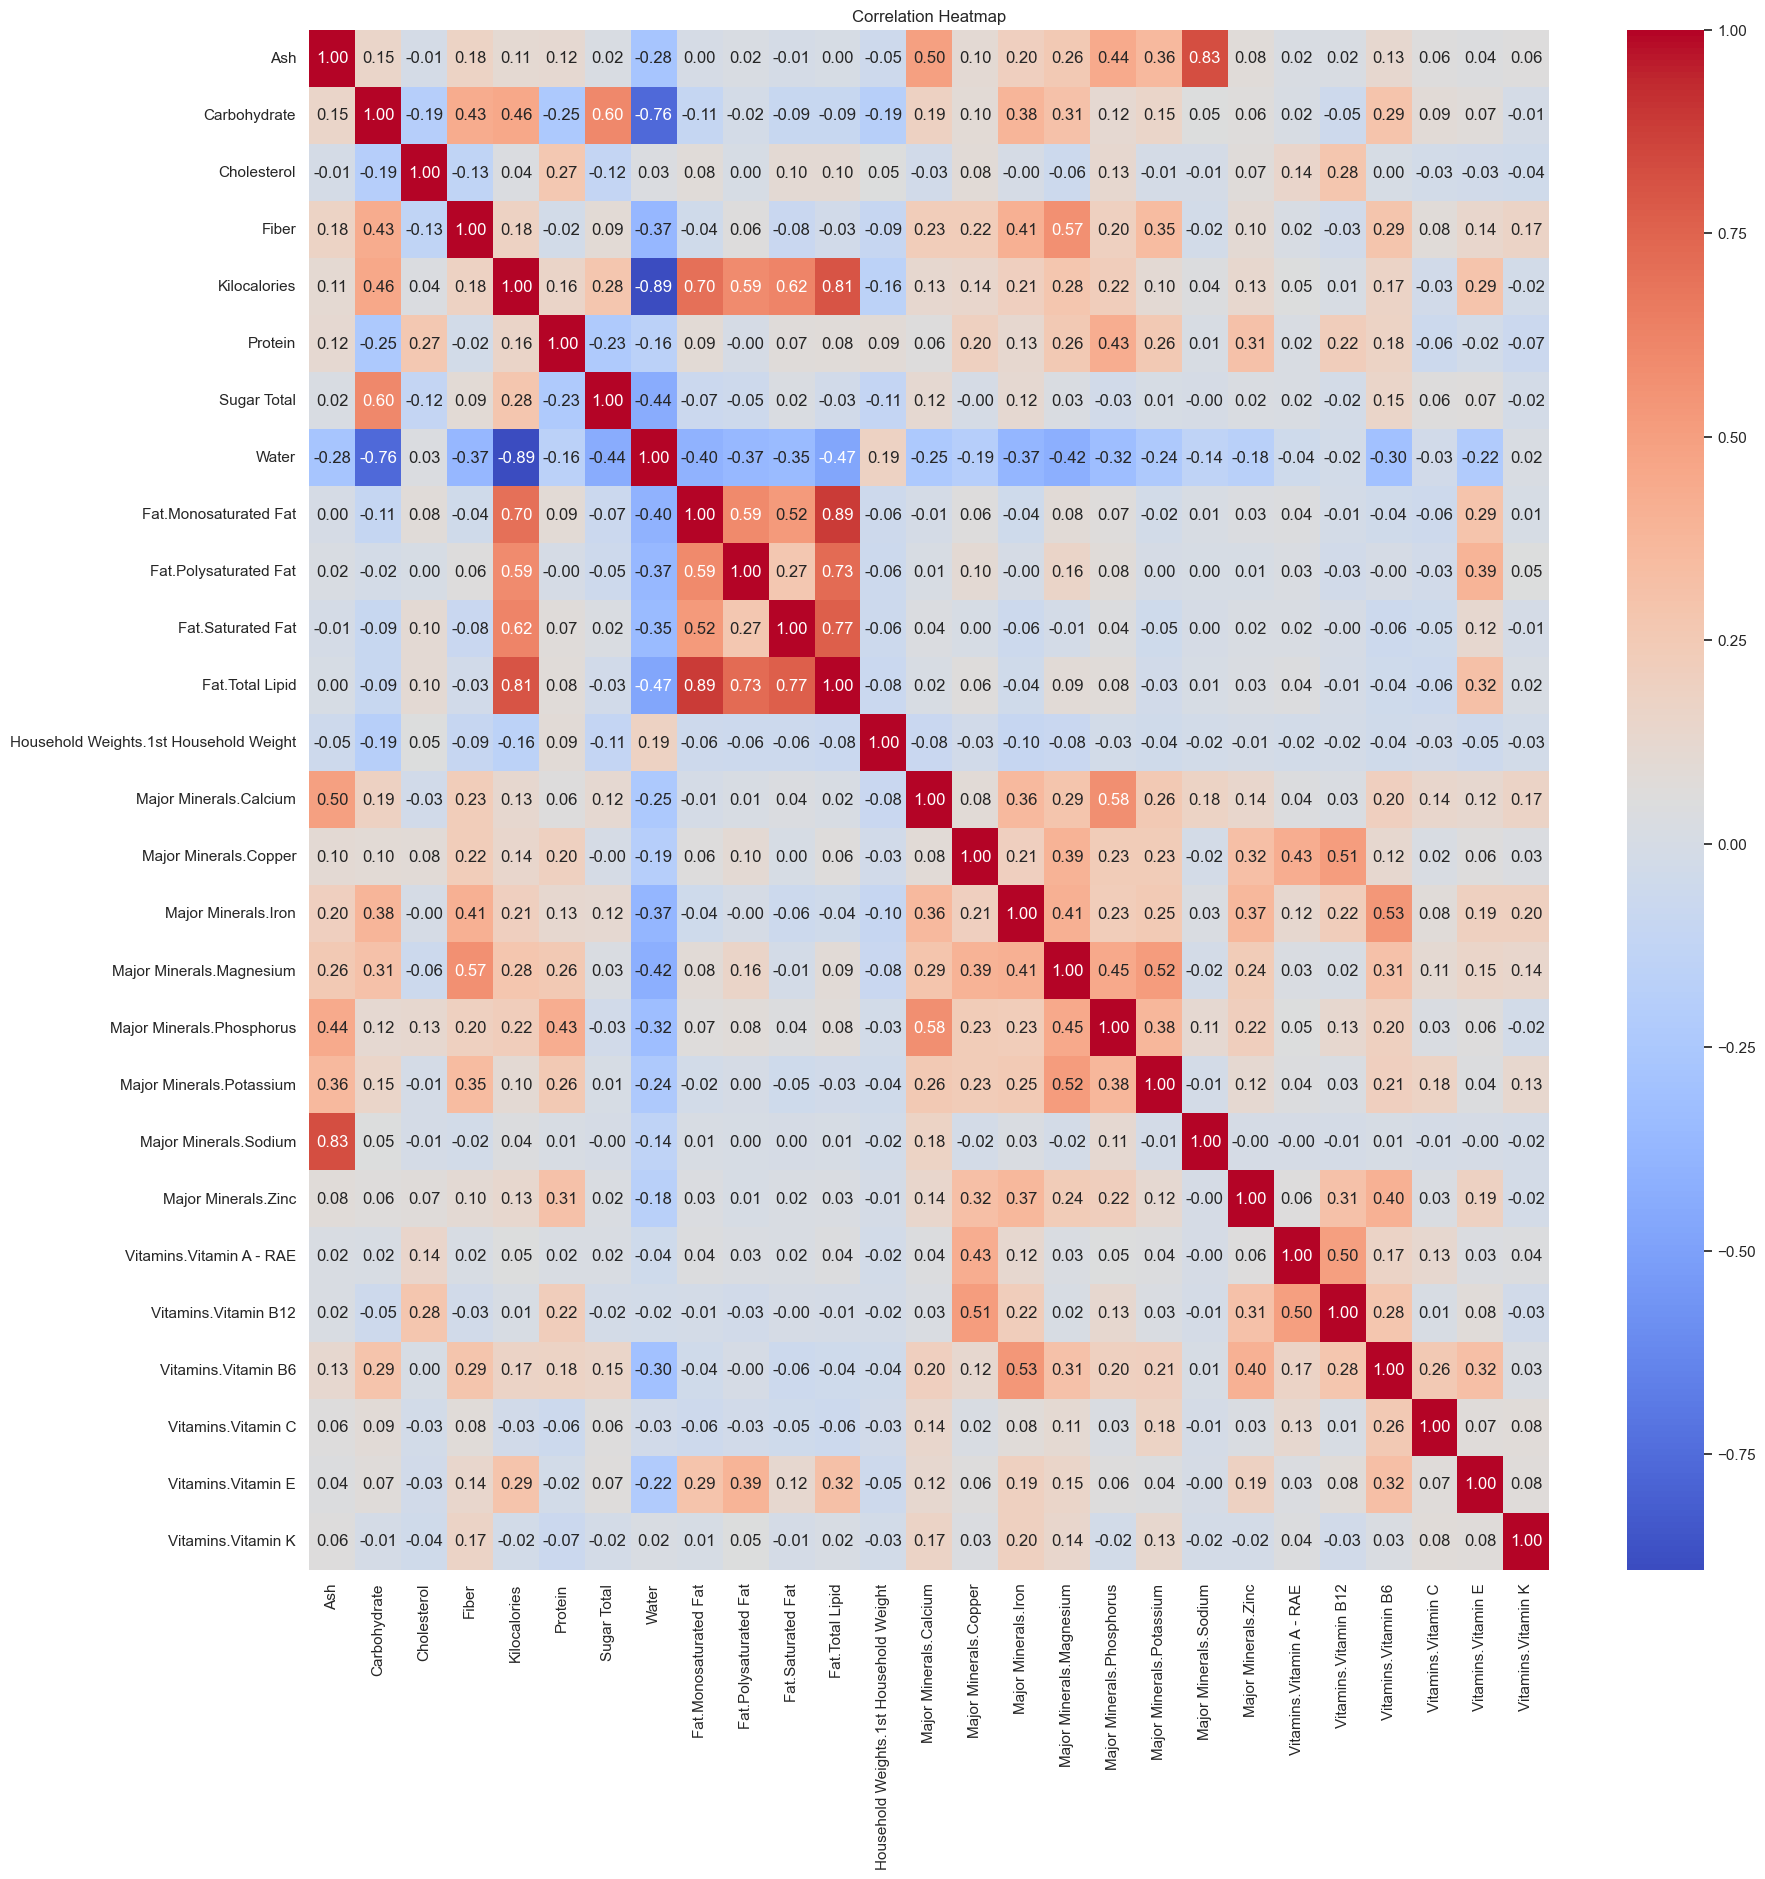

In [624]:
# Create a correlation matrix of all independent variables
corr_matrix = df_fs_correlation.corr()

# Create a heatmap of all independent variables
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


A few things jump out at us from the heatmap that will help us narrow down our features:
1.  *Fat.Total Lipid* and the other sub-types of fat (e.g. *Monounsaturated*, *Saturated*) are highly correlated to each other. This makes sense because Total Lipid is the sum of the other sub-types of fat. Because we are trying to predict *Kilocalories*, we will keep *Fat.Total Lipid* and drop the other sub-types of fat. The high correlation shows us that Total Fat will likely be our best predictor of Calories and this will help mitigate the multi-collinearity between the sub-types of fat.
2. Water's negative correlation to *Kilocalories* will likely make it a great feature to keep. Because foods like vegetables are mostly water and have few calories this makes sense.
3. Major Minerals seem to be clustered together as well, for example *Calcium* and *Phosphorus* are highly correlated. None of these minerals are highly correlated to *Kilocalories*, so we will drop them.
4. Interestingly *Sodium* and *Ash* are highly correlated. The relationship between these two is not clear. Because we dropped Sodium in the previous step, we will keep Ash.
5. None of the vitamins are highly correlated to *Kilocalories*, so we will drop them.

In [625]:
# Drop columns that Pearson's test highlighted as not useful above
df_fs_correlation.drop(['Fat.Monosaturated Fat', 'Fat.Polysaturated Fat', 'Fat.Saturated Fat', 'Major Minerals.Calcium', 'Major Minerals.Copper', 'Major Minerals.Iron', 'Major Minerals.Magnesium', 'Major Minerals.Phosphorus', 'Major Minerals.Potassium', 'Major Minerals.Sodium', 'Major Minerals.Zinc', 'Vitamins.Vitamin A - RAE', 'Vitamins.Vitamin B12', 'Vitamins.Vitamin B6', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E', 'Vitamins.Vitamin K'], axis=1, inplace=True)

# Show our current Feature Set after analysis of Pearson's Correlation
df_fs_correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6943 entries, 0 to 7409
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Ash                                     6943 non-null   float64
 1   Carbohydrate                            6943 non-null   float64
 2   Cholesterol                             6943 non-null   int64  
 3   Fiber                                   6943 non-null   float64
 4   Kilocalories                            6943 non-null   int64  
 5   Protein                                 6943 non-null   float64
 6   Sugar Total                             6943 non-null   float64
 7   Water                                   6943 non-null   float64
 8   Fat.Total Lipid                         6943 non-null   float64
 9   Household Weights.1st Household Weight  6943 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 596.7 KB


Next, let's use ***Sequential Feature Selection*** to select the best features. We will use a step size of 1 and a cross-validation of 5.

In [626]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X = df_fs_SFS.drop(['Kilocalories'], axis=1)
y = df_fs_SFS[['Kilocalories']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Initialize the SequentialFeatureSelector
sfs = SFS(model,
          k_features='best',  # Select the best number of features automatically
          forward=True,  # Perform forward feature selection
          floating=False,  # No floating feature selection
          scoring='neg_mean_squared_error',  # Scoring metric (RMSE in this case)
          cv=5  # Cross-validation folds
          )

# Fit the SFS object to the training data
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices and names
selected_feature_indices = sfs.k_feature_idx_
selected_feature_names = X.columns[list(selected_feature_indices)]

# Get the best subset of features
best_subset = X_train.iloc[:, list(selected_feature_indices)]

# Fit the model with the best subset of features
model.fit(best_subset, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test[selected_feature_names])

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Print the selected feature names
print("Selected Features:", selected_feature_names)

# Update df_fs_SFS to only include the selected features
df_fs_SFS = df_fs_SFS[selected_feature_names]

RMSE with selected features: 14.398572009995988
Selected Features: Index(['Ash', 'Carbohydrate', 'Cholesterol', 'Fiber', 'Sugar Total', 'Water',
       'Fat.Monosaturated Fat', 'Fat.Total Lipid',
       'Household Weights.1st Household Weight', 'Major Minerals.Copper',
       'Major Minerals.Magnesium', 'Major Minerals.Potassium',
       'Vitamins.Vitamin B12', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E'],
      dtype='object')


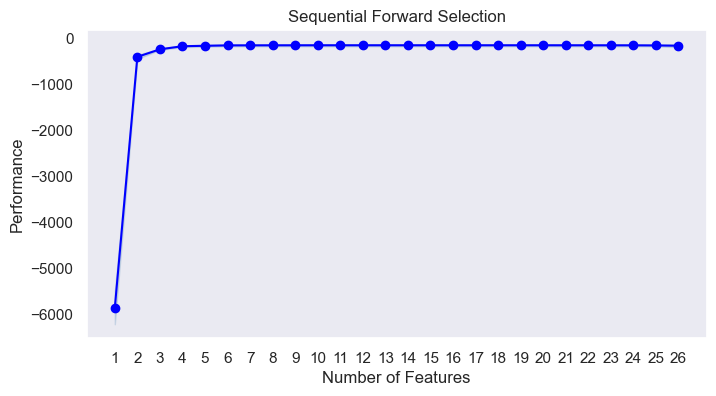

In [627]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

As we can see above, the Sequential Feature Selection method resulted in similar results to the Pearson's Correlation method. That said:
1. Again, we should follow the principle above to drop the sub-types of fat and keep *Fat.Total Lipid*.
2. This method indicates that micronutrients like *Vitamin B6* and *Copper*  may have a larger impact on *Kilocalories* than the others, but we will drop them all because it will affect the interpretibility of our model - it may lead us to false conclusions (e.g. high Copper foods are super low cal!). Keeping some of these micronutrients may also cause multi-collinearity issues with the other micronutrients.
3. Interestingly, this method indicated that *Protein* may not be a good predictor of *Kilocalories*. This makes sense because protein

Finally, let's use ***Variance Thresholding***. This is a simple method that removes features whose variance does not meet a certain threshold. Given our right-tailed histograms, we should take this step to ensure our features are decently spread out. We will use a threshold of 0.2.

Because we have a good idea of what our features are from the methods above, we will use the intersection of the features from the Pearson's Correlation method and the Sequential Feature Selection method and exclude anything that doesn't meet our threshold.

In [628]:
# Create a VarianceThreshold object with a threshold of 0.2
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.2)

# Fit the VarianceThreshold object to ds_fs_ffs
vt.fit(df_fs_vt)

# Create a boolean mask from the VarianceThreshold object
mask = vt.get_support()

# Create a reduced dataset by applying the mask to ds_fs_ffs
reduced_ds_fs_ffs = df_fs_vt.loc[:, mask]

# Create a list of features to keep
df_selected_features = reduced_ds_fs_ffs.copy()

# Show the list of features to keep
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6943 entries, 0 to 7409
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Ash                                     6943 non-null   float64
 1   Carbohydrate                            6943 non-null   float64
 2   Cholesterol                             6943 non-null   int64  
 3   Fiber                                   6943 non-null   float64
 4   Kilocalories                            6943 non-null   int64  
 5   Protein                                 6943 non-null   float64
 6   Sugar Total                             6943 non-null   float64
 7   Water                                   6943 non-null   float64
 8   Fat.Monosaturated Fat                   6943 non-null   float64
 9   Fat.Polysaturated Fat                   6943 non-null   float64
 10  Fat.Saturated Fat                       6943 non-null   floa

This shows us that none of the features have a variance less than 0.2. None of the features will be excluded in this step.

Our best features seem to be the ones we identified in the correlation method. Let's keep those and move on to the next step.

In [629]:
# Our final features end up being the ones we identified in the correlation method
df_selected_features = df_fs_correlation.copy()

df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6943 entries, 0 to 7409
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Ash                                     6943 non-null   float64
 1   Carbohydrate                            6943 non-null   float64
 2   Cholesterol                             6943 non-null   int64  
 3   Fiber                                   6943 non-null   float64
 4   Kilocalories                            6943 non-null   int64  
 5   Protein                                 6943 non-null   float64
 6   Sugar Total                             6943 non-null   float64
 7   Water                                   6943 non-null   float64
 8   Fat.Total Lipid                         6943 non-null   float64
 9   Household Weights.1st Household Weight  6943 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 596.7 KB


## Selected Feature Significance
With our selected features, let's now determine which features are the most significant. We will use the Ordinary Least Squares (OLS) method to determine the significance of each feature. We will use a significance level of 0.05.

In [630]:
# Create a model of the numeric features in df_fs_OLS with the target variable Kilocalories
model = sm.OLS(df_selected_features['Kilocalories'], df_selected_features.drop(['Kilocalories'], axis=1)).fit()

# Show the summary of the model
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:           Kilocalories   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.192e+05
Date:                Sun, 01 Oct 2023   Prob (F-statistic):                        0.00
Time:                        19:00:00   Log-Likelihood:                         -29333.
No. Observations:                6943   AIC:                                  5.868e+04
Df Residuals:                    6934   BIC:                                  5.875e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

**Which predictor variables are the most important?**
Considering the P values of <0.05 tell us that the probability of a feature being significant is low, the OLS method tells us the following.

1. Following our discovery in the correlation step, *Fat.Total Lipid* is the most important predictor of Kilocalories, followed by Protein and Carbohydrates. Of course, we expect our macronutrients to drive the majority of calories.
2. When it comes to negative predictors of Kilocalories, *Fiber* overindexes other features. Fiborous vegetables are low in calories, so this makes sense.
3. Surprisingly, *Water* is just barely significant. This is likely because the majority of foods are mostly water, so it is not a good predictor of Kilocalories. Also, foods like soups and stews are mostly water and have a lot of calories, so this may be why the coefficient is negative.
4. Also unexpectedly, *Sugar Total* has a relatively low coefficient. This is likely because sugar is a type of carbohydrate and is already accounted for in the *Carbohydrate* feature.

**Are the predictor variables independent of all the other predictor variables?**
In the OLS summary above we can see that the Durbin-Watson statistic is less than one. This statistic tests for autocorrelation. The value of .987 is close to 2, which [indicates that there is positive autocorrelation](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp) in the data. This means that the predictor variables are probably correlated.

As stated above, Carbohydrates and Sugar Total are obviously related. Similarly Cholesterol and Fat.Total Lipid are related. We will keep these features in our model because they are significant predictors of Kilocalories.

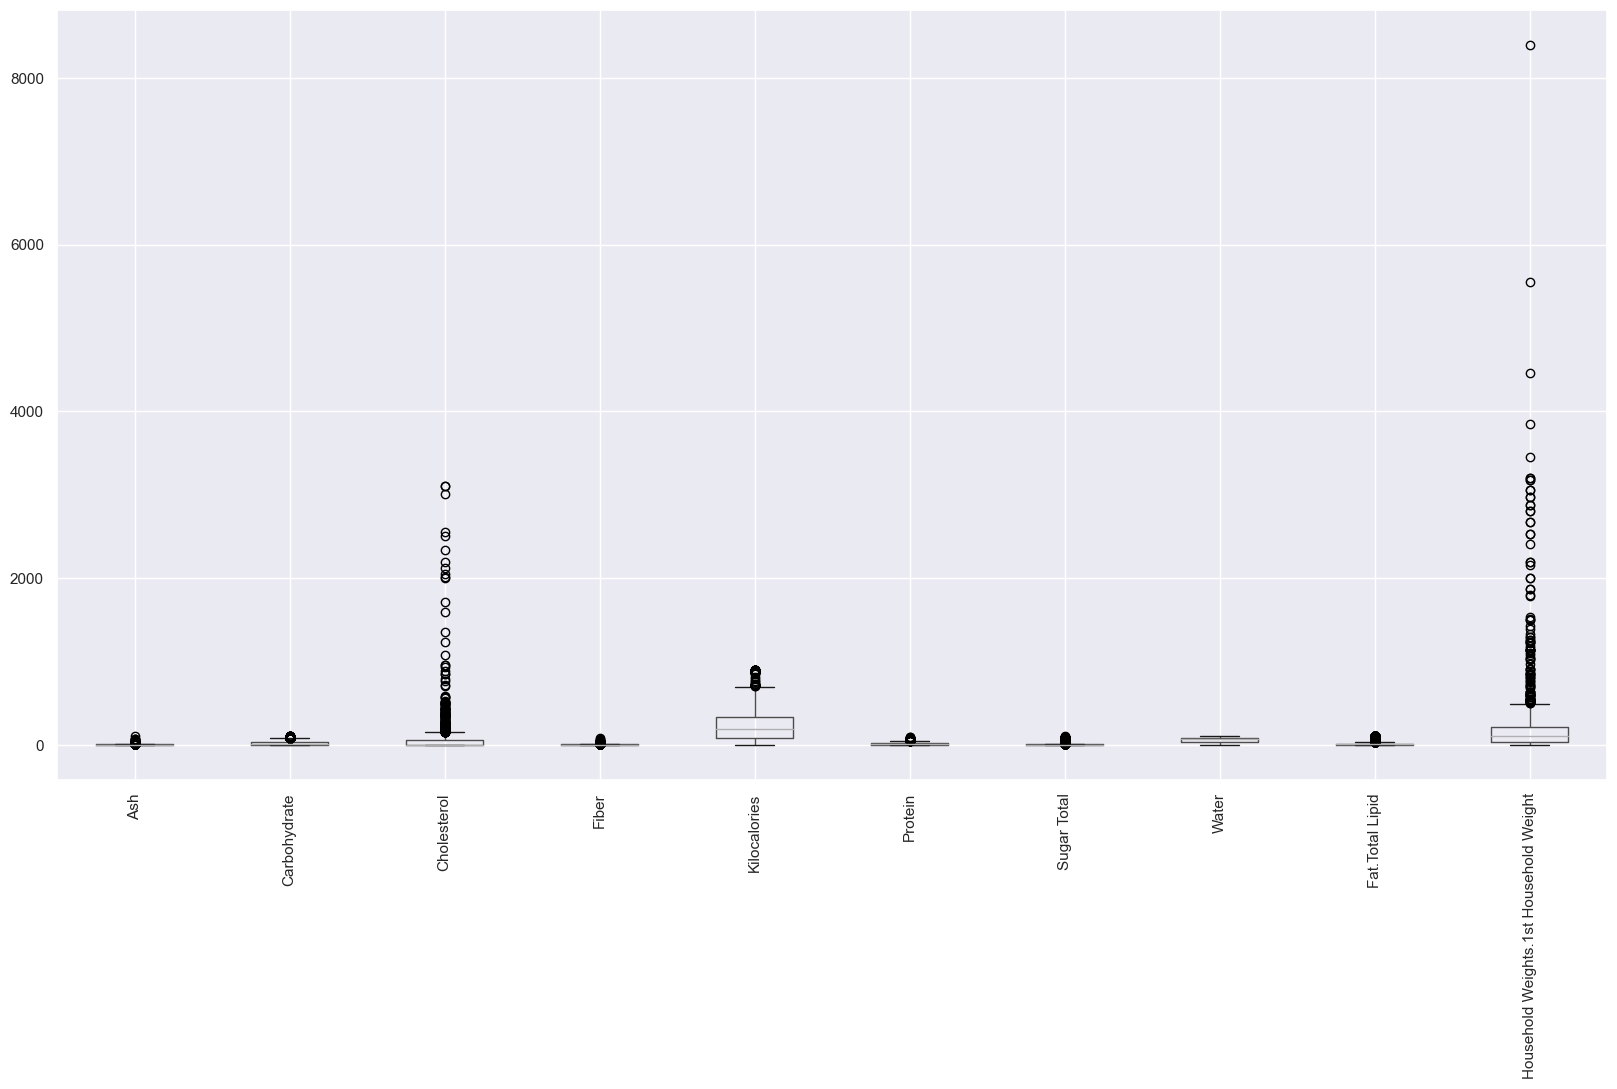

,count,mean,std,min,25%,50%,75%,max
Ash,6943.0,1.868766,3.065347,0.0,0.850,1.25,2.200,99.800000
Carbohydrate,6943.0,22.070084,27.194724,0.0,0.745,9.54,31.515,100.000000
Cholesterol,6943.0,36.920784,121.647215,0.0,0.000,2.00,59.000,3100.000000
Fiber,6943.0,2.031082,4.309378,0.0,0.000,0.40,2.400,79.000000
Kilocalories,6943.0,220.451390,171.796761,0.0,82.000,184.00,332.000,902.000000
Protein,6943.0,10.663995,10.252689,0.0,2.100,7.14,18.470,88.320000
Sugar Total,6943.0,6.533880,14.028581,0.0,0.000,0.34,4.815,99.910004
Water,6943.0,54.975558,31.035121,0.0,30.100,63.87,80.010,100.000000
Fat.Total Lipid,6943.0,10.259528,16.476994,0.0,0.730,4.32,13.100,100.000000
Household Weights.1st Household Weight,6943.0,144.366264,246.086429,0.2,28.350,103.00,214.000,8399.000000


In [631]:
# Visualize the ranges of the features with boxplots
df_selected_features.boxplot(rot=90, figsize=(20, 10))
plt.show()
# Show ranges of the features with boxplots
df_selected_features.describe().T

**Do the ranges of the predictor variables make sense?** A few things seem odd about the ranges of the features:
1. The range of *Fat.Total Lipid*, *Water*, and *Carbohydrate* is 0-100. This is odd because fat is measured in grams and the range of each seem arbitrarily locked at 100.
2. The Household Weight of each food is measured in grams, but the range max is 8399 g. This makes sense because the heaviest food in the dataset is 8399 g, which is 18.5 lbs. Though this is an outlier, the entry is for a Turkey which sounds about right.

**What are the distributions of the predictor variables?** The distributions of the predictor variables are right-tailed and not normal. As explained earlier, this is expected because not all foods have the same nutritional value.

## Model Building
Now that we have our selected features, let's build a model to predict Kilocalories. We will use a Linear Regression model because we are predicting a continuous variable.

From there, we'll make some tweaks to our training data to see if we can improve the model's performance as measured by RMSE and R^2.

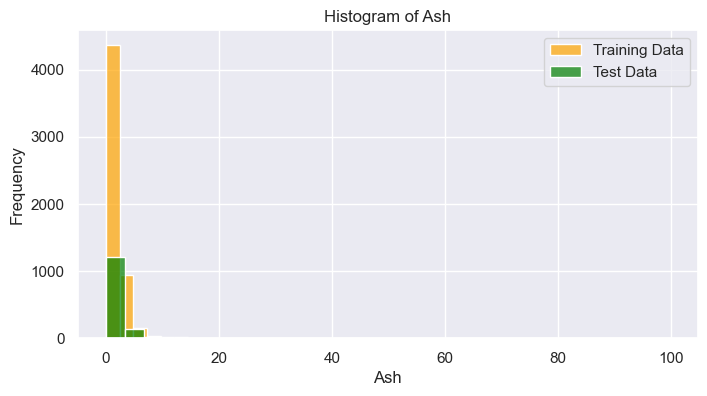

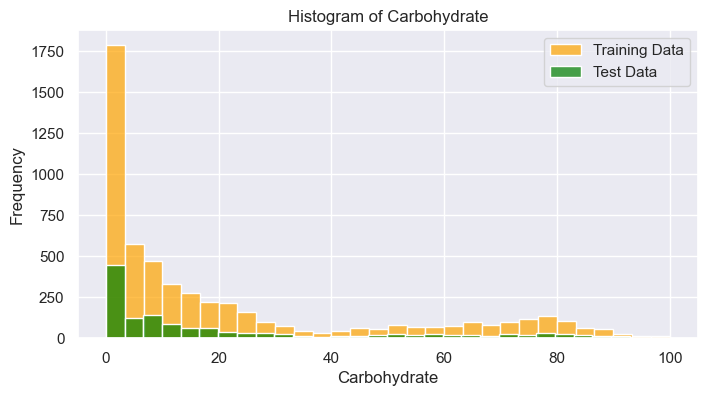

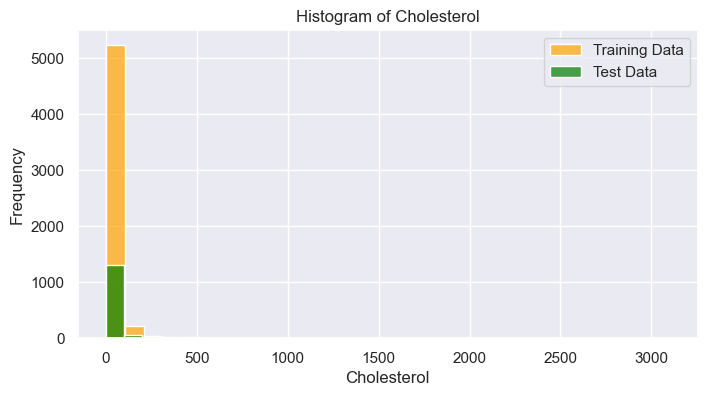

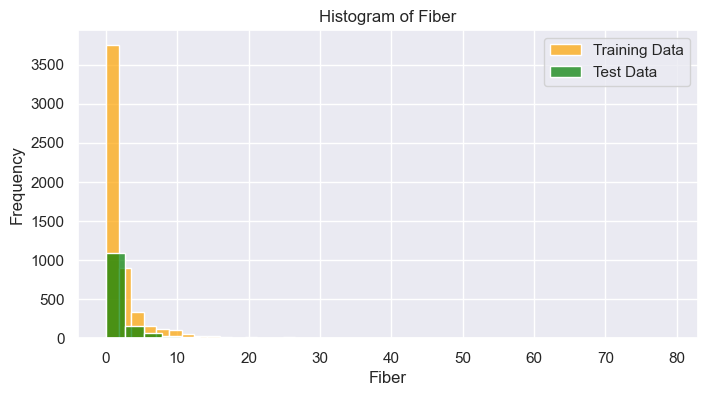

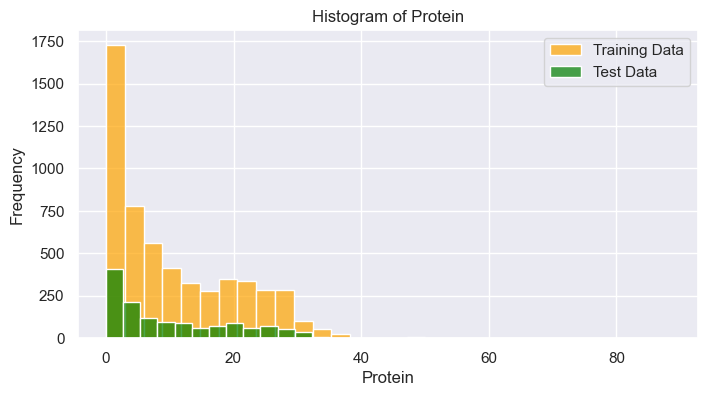

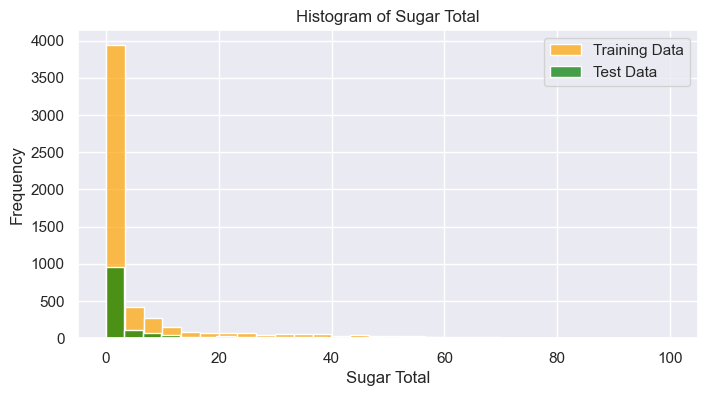

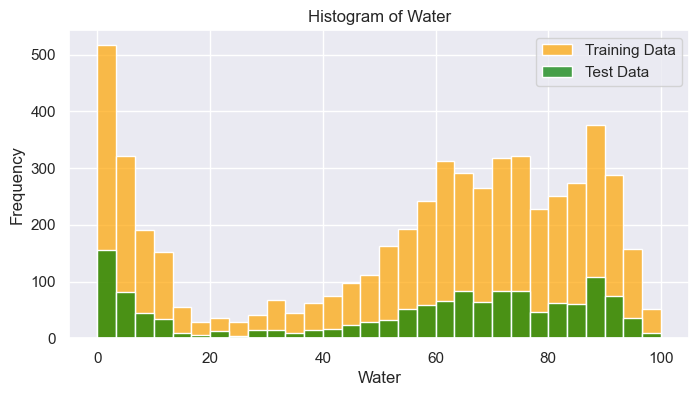

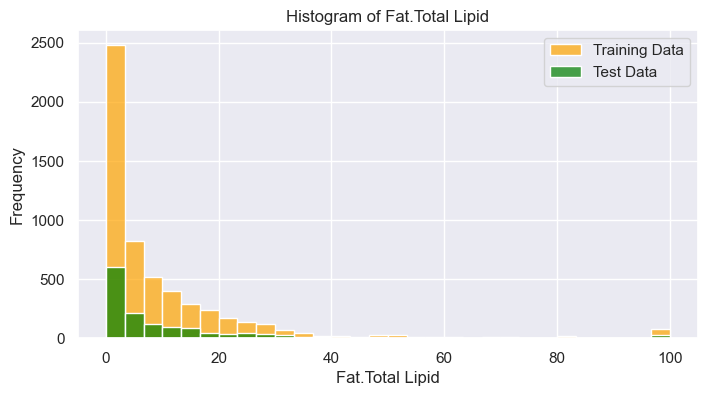

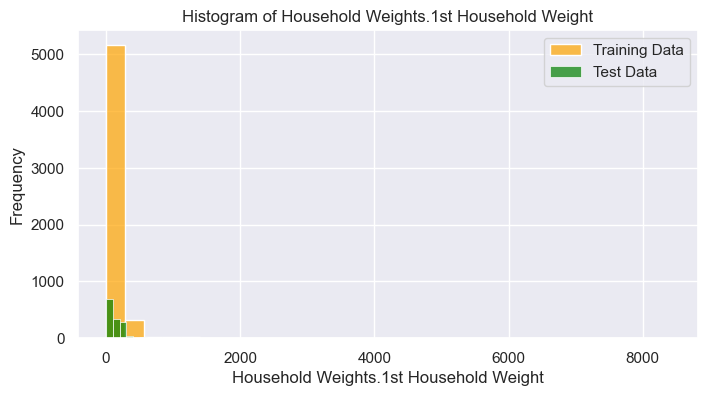

In [632]:
from sklearn.model_selection import train_test_split

# Using df_selected_features, split the data into training and test sets where 20% of the data is in the test set
X = df_selected_features.drop(['Kilocalories'], axis=1)
y = df_selected_features[['Kilocalories']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For each feature, plot histograms of the feature in the training and test sets
for column in X_train.columns:
    sns.set(rc={"figure.figsize": (8, 4)})

    # Create histograms for training data in orange with opacity
    sns.histplot(X_train[column], color='orange', alpha=0.7, bins=30, label='Training Data')

    # Create histograms for test data in green with opacity
    sns.histplot(X_test[column], color='green', alpha=0.7, bins=30, label='Test Data')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

In [633]:
# Let's train the model on our training data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train.columns)):
    print(f'{X_train.columns[i]}: {model.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model.intercept_[0]}')

Model Coefficients:
Ash: -5.417614251211846
Carbohydrate: -0.6823806600691329
Cholesterol: 0.004921372859685136
Fiber: -2.2346184512477656
Protein: -0.41510178620611704
Sugar Total: -0.06742808183523451
Water: -4.650921352671233
Fat.Total Lipid: 4.149209059062596
Household Weights.1st Household Weight: -0.0005155698506266503
Intercept: 468.1561269012351


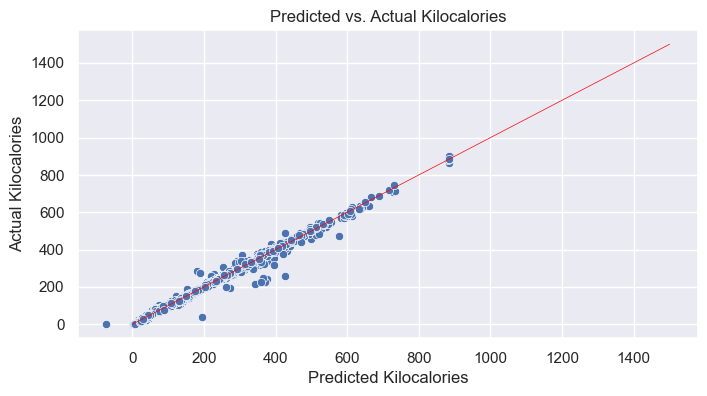

RMSE with selected features: 15.743887800221012
R^2 with selected features: 0.9920133805445984


In [634]:
# Let's take a look at the model's performance on the full dataset's test data
# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot RSME vs. Predicted Kilocalories
sns.scatterplot(x=y_pred.flatten(), y=y_test.values.flatten())

# Plot a line from (0,0) to (5000, 5000)
plt.plot([0, 1500], [0, 1500], color='red', lw=.5)

# Set the x and y axes labels
plt.xlabel('Predicted Kilocalories')
plt.ylabel('Actual Kilocalories')

# Set the plot title and show the plot
plt.title('Predicted vs. Actual Kilocalories')
plt.show()

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Calculate R^2 on the test set
r2 = model.score(X_test, y_test)
print(f"R^2 with selected features: {r2}")

The model's R^2 is 0.999, which is very high. This means that the model explains 99.2% of the variance in the data. This is likely means the model is overfitting the data. Our RSME is 15.7, which is not bad considering the range of Kilocalories is 0-902.

Let's see what happens when we remove the outliers from the dataset and retrain.

In [635]:
# Create a copy of the dataset
df_no_outliers = df_selected_features.copy()

# For each feature, calculate the mean and standard deviation of the feature. Then, remove the entire record if outliers that are more than 3 standard deviations from the mean exist for a given feature.
for column in df_no_outliers.columns:
    if column != 'Kilocalories':
        mean = df_selected_features[column].mean()
        std = df_selected_features[column].std()
        # For each row in df_no_outliers If the value is more than 3 standard deviations from the mean, remove the row from df_no_outliers
        df_no_outliers = df_no_outliers[(df_no_outliers[column] - mean) / std < 3]

# Show the shape of the dataset
df_no_outliers.shape

(6239, 10)

In [636]:
# Using df_no_outliers, let's train our model on all of the outlier-free training data
X = df_no_outliers.drop(['Kilocalories'], axis=1)
y = df_no_outliers[['Kilocalories']]

# We won't create a test set because we will use the same test set as before - we'll just create/use training data for our outlier free model
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_no_outlier = LinearRegression()

# Fit the model to the training data
model_no_outlier.fit(X_train_2, y_train_2)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_2.columns)):
    print(f'{X_train_2.columns[i]}: {model_no_outlier.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_no_outlier.intercept_[0]}')

Model Coefficients:
Ash: -7.183788635124808
Carbohydrate: -1.8386984768720105
Cholesterol: 0.02784835622438321
Fiber: -1.586819458799139
Protein: -1.4703990599796235
Sugar Total: 0.031309380495498716
Water: -5.777343428165345
Fat.Total Lipid: 2.965540109192594
Household Weights.1st Household Weight: -0.002632879069171177
Intercept: 580.0672371234739


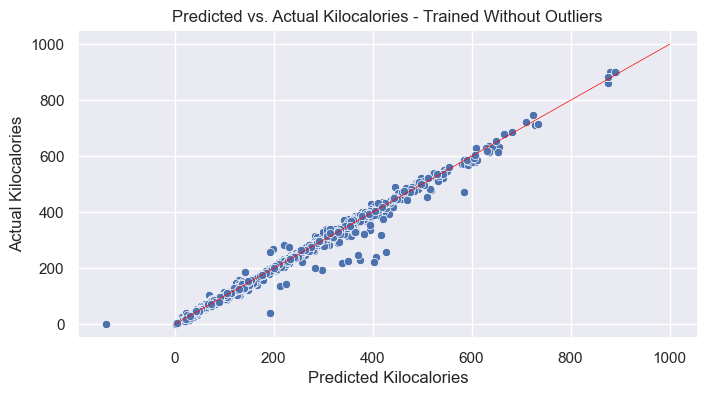

RMSE with selected features: 16.921124648302843
R^2 with selected features: 0.9920133805445984


In [637]:
# Let's take a look at the model's performance on the same testing data from the full dataset
# Make predictions on the test set
y_pred = model_no_outlier.predict(X_test)

# Plot RSME vs. Predicted Kilocalories
sns.scatterplot(x=y_pred.flatten(), y=y_test.values.flatten())

# Plot a line from (0,0) to (5000, 5000)
plt.plot([0, 1000], [0, 1000], color='red', lw=0.5)

# Set the x and y axes labels
plt.xlabel('Predicted Kilocalories')
plt.ylabel('Actual Kilocalories')

# Set the plot title and show the plot
plt.title('Predicted vs. Actual Kilocalories - Trained Without Outliers')
plt.show()

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse}")

# Calculate R^2 on the test set
r2 = model.score(X_test, y_test)
print(f"R^2 with selected features: {r2}")

**Remove outliers and keep outliers (does it have an effect of the final predictive model)?** Removing the outliers from the dataset did not have a significant effect on the model's performance. The model's R^2 is still 0.992, which is very high.

Also, our RSME is 16.9, which is really not bad considering the range of Kilocalories is 0-902.

## Impact of Imputation
Let's see what happens if we remove some random records from the dataset, impute those values, and retrain.

In [638]:
# Create a copy of the dataset
df_1_per_random = df_selected_features.copy()
df_5_per_random = df_selected_features.copy()
df_10_per_random = df_selected_features.copy()

# Calculate the number of cells in the dataset
num_cells = df_1_per_random.shape[0] * df_1_per_random.shape[1]

# For 1% of the cells in the dataset, randomly choose a row and column index and replace the value with -100000
for i in range(int(num_cells * 0.01)):
    # Choose a random row index
    row_index = np.random.randint(0, df_1_per_random.shape[0])

    # Choose a random column index
    col_index = np.random.randint(0, df_1_per_random.shape[1])

    # Replace the value with -100000
    df_1_per_random.iloc[row_index, col_index] = -100000

# For 1% of the cells in the dataset, randomly choose a row and column index and replace the value with -100000
for i in range(int(num_cells * 0.05)):
    # Choose a random row index
    row_index = np.random.randint(0, df_5_per_random.shape[0])

    # Choose a random column index
    col_index = np.random.randint(0, df_5_per_random.shape[1])

    # Replace the value with -100000
    df_5_per_random.iloc[row_index, col_index] = -100000

# For 1% of the cells in the dataset, randomly choose a row and column index and replace the value with -100000
for i in range(int(num_cells * 0.1)):
    # Choose a random row index
    row_index = np.random.randint(0, df_10_per_random.shape[0])

    # Choose a random column index
    col_index = np.random.randint(0, df_10_per_random.shape[1])

    # Replace the value with -100000
    df_10_per_random.iloc[row_index, col_index] = -100000
# Compare the count of ImputeMe values in each dataset
print('1% Missing Values: {}'.format(df_1_per_random.isin([-100000]).sum().sum()))
print('5% Missing Values: {}'.format(df_5_per_random.isin([-100000]).sum().sum()))
print('10% Missing Values: {}'.format(df_10_per_random.isin([-100000]).sum().sum()))


1% Missing Values: 691
5% Missing Values: 3376
10% Missing Values: 6610


Now let's try imputing the missing values of the random records we removed above. We will use three methods to replace the missing values:
1. **Mean**: We will replace the missing values with the mean of the column. We will apply this to the 1% missing values dataset.
2. **Median**: We will replace the missing values with the median of the column. We will apply this to the 5% missing values dataset.
3. **Mode**: We will replace the missing values with the mode of the column. We will apply this to the 10% missing values dataset.

In [639]:
# For each column in df_1_per_random, replace the -100000 values with the mean of the column in df_selected_features
for column in df_1_per_random.columns:
    # Calculate the mean of the column in df_selected_features
    mean = df_selected_features[column].mean()

    # Replace the -100000 values with the mean
    df_1_per_random[column].replace(-100000, mean, inplace=True)

# For each column in df_5_per_random, replace the -100000 values with the Median of the column in df_selected_features
for column in df_5_per_random.columns:
    # Calculate the Median of the column in df_selected_features
    median = df_selected_features[column].median()

    # Replace the -100000 values with the Median
    df_5_per_random[column].replace(-100000, median, inplace=True)

# For each column in df_10_per_random, replace the -100000 values with the Mode of the column in df_selected_features
for column in df_10_per_random.columns:
    # Calculate the Mode of the column in df_selected_features
    mode = df_selected_features[column].mode()[0]

    # Replace the -100000 values with the Mode
    df_10_per_random[column].replace(-100000, mode, inplace=True)

# Show the descriptions of our three imputed datasets
df_1_per_random.describe().T

,count,mean,std,min,25%,50%,75%,max
Ash,6943.0,1.873048,3.063539,0.0,0.85,1.27,2.200,99.800000
Carbohydrate,6943.0,22.070936,27.044630,0.0,0.81,9.80,30.900,100.000000
Cholesterol,6943.0,36.963349,121.581950,0.0,0.00,2.00,59.000,3100.000000
Fiber,6943.0,2.028600,4.265696,0.0,0.00,0.40,2.300,79.000000
Kilocalories,6943.0,220.671275,171.109059,0.0,83.00,187.00,331.000,902.000000
Protein,6943.0,10.654143,10.212603,0.0,2.11,7.26,18.300,88.320000
Sugar Total,6943.0,6.533365,13.978542,0.0,0.00,0.37,5.010,99.910004
Water,6943.0,54.967098,30.912084,0.0,30.71,63.56,79.970,100.000000
Fat.Total Lipid,6943.0,10.276090,16.405041,0.0,0.75,4.43,12.985,100.000000
Household Weights.1st Household Weight,6943.0,144.624256,245.853353,0.2,29.00,106.00,210.000,8399.000000


In [640]:
df_5_per_random.describe().T

,count,mean,std,min,25%,50%,75%,max
Ash,6943.0,1.841368,3.028307,0.0,0.880,1.25,2.120,99.800000
Carbohydrate,6943.0,21.492486,26.692841,0.0,1.205,9.54,29.025,100.000000
Cholesterol,6943.0,35.596284,121.270622,0.0,0.000,2.00,57.000,3100.000000
Fiber,6943.0,1.951174,4.212588,0.0,0.000,0.40,2.200,79.000000
Kilocalories,6943.0,218.178021,167.374390,0.0,86.000,184.00,322.000,902.000000
Protein,6943.0,10.521894,10.069178,0.0,2.300,7.14,17.810,88.320000
Sugar Total,6943.0,6.196474,13.729434,0.0,0.000,0.34,4.260,99.910004
Water,6943.0,55.388612,30.378072,0.0,33.585,63.87,79.120,100.000000
Fat.Total Lipid,6943.0,9.972074,16.072723,0.0,0.820,4.32,12.510,100.000000
Household Weights.1st Household Weight,6943.0,140.617435,216.682626,0.2,29.570,103.00,204.015,5554.000000


In [641]:
df_10_per_random.describe().T

,count,mean,std,min,25%,50%,75%,max
Ash,6943.0,1.694351,3.035797,0.0,0.620,1.15,2.030,99.800000
Carbohydrate,6943.0,19.965325,26.706362,0.0,0.000,7.40,26.615,100.000000
Cholesterol,6943.0,34.324788,120.865746,0.0,0.000,0.00,55.000,3100.000000
Fiber,6943.0,1.856705,4.201401,0.0,0.000,0.00,2.100,79.000000
Kilocalories,6943.0,290.225695,260.227449,0.0,92.000,212.00,381.000,902.000000
Protein,6943.0,9.680936,10.189923,0.0,1.245,5.80,17.160,88.320000
Sugar Total,6943.0,5.918390,13.468156,0.0,0.000,0.00,3.950,99.910004
Water,6943.0,49.404144,33.643452,0.0,7.800,60.37,77.545,100.000000
Fat.Total Lipid,6943.0,9.439496,16.185021,0.0,0.300,3.45,11.885,100.000000
Household Weights.1st Household Weight,6943.0,134.063810,241.592494,0.2,28.350,85.00,195.000,8399.000000


In [645]:
# Show the description of our original dataset
df_selected_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Ash,6943.0,1.868766,3.065347,0.0,0.850,1.25,2.200,99.800000
Carbohydrate,6943.0,22.070084,27.194724,0.0,0.745,9.54,31.515,100.000000
Cholesterol,6943.0,36.920784,121.647215,0.0,0.000,2.00,59.000,3100.000000
Fiber,6943.0,2.031082,4.309378,0.0,0.000,0.40,2.400,79.000000
Kilocalories,6943.0,220.451390,171.796761,0.0,82.000,184.00,332.000,902.000000
Protein,6943.0,10.663995,10.252689,0.0,2.100,7.14,18.470,88.320000
Sugar Total,6943.0,6.533880,14.028581,0.0,0.000,0.34,4.815,99.910004
Water,6943.0,54.975558,31.035121,0.0,30.100,63.87,80.010,100.000000
Fat.Total Lipid,6943.0,10.259528,16.476994,0.0,0.730,4.32,13.100,100.000000
Household Weights.1st Household Weight,6943.0,144.366264,246.086429,0.2,28.350,103.00,214.000,8399.000000


Now that we've imputed the missing values, let's train some new models on our imputed datasets.

In [642]:
# Using df_1_per_random, let's train a model on mean-replaced data
X = df_1_per_random.drop(['Kilocalories'], axis=1)
y = df_1_per_random[['Kilocalories']]

# We won't create a test set because we will use the same test set as before
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_mean = LinearRegression()

# Fit the model to the training data
model_mean.fit(X_train_3, y_train_3)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_3.columns)):
    print(f'{X_train_3.columns[i]}: {model_mean.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_mean.intercept_[0]}')

Model Coefficients:
Ash: -3.954441879211915
Carbohydrate: 0.7400110317915838
Cholesterol: 0.004643987909891418
Fiber: -2.0091813860257726
Protein: 0.9810998985000697
Sugar Total: -0.06401937551943893
Water: -3.1904061164980053
Fat.Total Lipid: 5.5836523336770005
Household Weights.1st Household Weight: 0.0006688529138802266
Intercept: 323.6467723731221


In [643]:
# Using df_5_per_random, let's train a model on median-replaced data
X = df_5_per_random.drop(['Kilocalories'], axis=1)
y = df_5_per_random[['Kilocalories']]

# We won't create a test set because we will use the same test set as before
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_median = LinearRegression()

# Fit the model to the training data
model_median.fit(X_train_4, y_train_4)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_4.columns)):
    print(f'{X_train_4.columns[i]}: {model_median.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_median.intercept_[0]}')

Model Coefficients:
Ash: -3.3641658727499126
Carbohydrate: 0.8584680689037116
Cholesterol: 0.007915799058860343
Fiber: -1.7214353356601917
Protein: 1.1817605426663513
Sugar Total: 0.12336270394486029
Water: -2.908461142925299
Fat.Total Lipid: 5.464932726292769
Household Weights.1st Household Weight: -0.005562019050700614
Intercept: 303.09420046690883


In [644]:
# Using df_10_per_random, let's train a model on mode-replaced data
X = df_10_per_random.drop(['Kilocalories'], axis=1)
y = df_10_per_random[['Kilocalories']]

# We won't create a test set because we will use the same test set as before
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y, random_state=42)

# Create a linear regression model
model_mode = LinearRegression()

# Fit the model to the training data
model_mode.fit(X_train_5, y_train_5)

# Let's take a look at the model's coefficient for each feature
print('Model Coefficients:')
for i in range(len(X_train_5.columns)):
    print(f'{X_train_4.columns[i]}: {model_mode.coef_[0][i]}')

# Let's take a look at the model's intercept
print(f'Intercept: {model_mode.intercept_[0]}')

Model Coefficients:
Ash: -0.19087031938067725
Carbohydrate: 1.942859479527571
Cholesterol: -0.011377951009885708
Fiber: 0.47486407718783635
Protein: 2.555970843618199
Sugar Total: 0.5905291876930747
Water: -1.0432511786657461
Fat.Total Lipid: 6.636056840728198
Household Weights.1st Household Weight: -0.018625722044472125
Intercept: 216.95424848288434


## References

1. [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
2. [ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb](https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/ML_Data_Cleaning_and_Feature_Selection/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb)
3. [USDA Food Data Banke](https://fdc.nal.usda.gov/index.html)
4. [NIH Fact Sheet](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE)
5. [Feature Selection Techniques - Vidhya.com](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/)
6. [Investopedia](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp)
7. [Imputation Methods](https://www.youtube.com/watch?v=fYhr8eF1ubo)